## Import Statements

In [63]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [64]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### Define Imputer for Missing Filling Values

### CLA Data

In [65]:
# impute = KNNImputer(
#     n_neighbors=5,
#     weights='uniform',
#     metric='nan_euclidean'
# )

In [66]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
# cla_2015.dropna(axis='rows', how='any', inplace=True)
# cla_2016.dropna(axis='rows', how='any', inplace=True)
# cla_2017.dropna(axis='rows', how='any', inplace=True)
# cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample the data to make a prediction about algae on lake mendota each day
cla_2015 = cla_2015.resample('D').mean()
# cla_2015 = pd.DataFrame(impute.fit_transform(cla_2015.values), index=cla_2015.index, columns=cla_2015.columns)

# use threshold of 0 vs 0.5 for detecting algalblooms since if one person detects an algal bloom, then 
# there definitely was an algalbloom    
for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1
    else:
        cla_2015.loc[date, 'algalBloomSheen'] = 0

cla_2016 = cla_2016.resample('D').mean()
# cla_2016 = pd.DataFrame(impute.fit_transform(cla_2016.values), index=cla_2016.index, columns=cla_2016.columns)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1
    else:
        cla_2016.loc[date, 'algalBloomSheen'] = 0

cla_2017 = cla_2017.resample('D').mean()
# cla_2017 = pd.DataFrame(impute.fit_transform(cla_2017.values), index=cla_2017.index, columns=cla_2017.columns)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1
    else:
        cla_2017.loc[date, 'algalBloomSheen'] = 0

cla_2018 = cla_2018.resample('D').mean()
# cla_2018 = pd.DataFrame(impute.fit_transform(cla_2018.values), index=cla_2018.index, columns=cla_2018.columns)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
    else:
        cla_2018.loc[date, 'algalBloomSheen'] = 0
        
# only keep the dates of the official sampling season of each year
# cla_2015 = cla_2015[(cla_2015.index >= '2015-5-18') & (cla_2015.index <= '2015-9-4')]
# cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
# cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
# cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

In [67]:
## 1/21/20. changed threshold of when to make a label 1 or 0 to 

print(cla_2015['algalBloomSheen'].sum()+\
cla_2016['algalBloomSheen'].sum()+\
cla_2017['algalBloomSheen'].sum()+\
cla_2018['algalBloomSheen'].sum())

print('2015')
for idx in cla_2015.index:
    if cla_2015.loc[idx, 'algalBloomSheen'] > 0:
        print(cla_2015.loc[idx, 'algalBloomSheen'], end=', ')
print()
print('2016')
for idx in cla_2016.index:
    if cla_2016.loc[idx, 'algalBloomSheen'] > 0:
        print(cla_2016.loc[idx, 'algalBloomSheen'], end=', ')
print()
print('2017')
for idx in cla_2017.index:
    if cla_2017.loc[idx, 'algalBloomSheen'] > 0:
        print(cla_2017.loc[idx, 'algalBloomSheen'], end=', ')
print()
print('2018')
for idx in cla_2018.index:
    if cla_2018.loc[idx, 'algalBloomSheen'] > 0:
        print(cla_2018.loc[idx, 'algalBloomSheen'], end=', ')
print()

218.0
2015
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
2016
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
2017
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
2018
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

### MDCP Data

In [53]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
# mdcp.ffill(inplace=True)
# mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
# mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
# mdcp = pd.DataFrame(impute.fit_transform(mdcp.values), index=mdcp.index, columns=mdcp.columns)

### Weather Data

In [54]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather['REPORTTPYE'].dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()

## Join CLA, MDCP, and Weather Data

In [60]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.sin(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# data = pd.DataFrame(impute.fit_transform(data.values), index=data.index, columns=data.columns)
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
# precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
# data['DAILYPrecip_one_day'] = precip.shift(1)
# data['DAILYPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()
# data['DAILYPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()

# data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
# data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].shift(1).rolling(3).sum()
# data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].shift(1).rolling(7).sum()

# shift algalbloomsheen by -1 to predict next day algal bloom
data['DAILYPrecip_one_day'] = data['DAILYPrecip']
data['DAILYPrecip_three_day'] = data['DAILYPrecip'].rolling(window=3, min_periods=1).sum()
data['DAILYPrecip_one_week'] = data['DAILYPrecip'].rolling(window=7, min_periods=1).sum()
precip = (data['DAILYPrecip'] > 0).astype(int)
data['COUNTPrecip_one_day'] = precip
data['COUNTPrecip_three_day'] = precip.rolling(window=3, min_periods=1).sum()
data['COUNTPrecip_one_week'] = precip.rolling(window=7, min_periods=1).sum()
# Important note: although predictions occur for the next day, the label for whether an algal bloom occured on
# any particular day is stored in algalBloomSheen_one_day. This is ok, since, each instance in the data set is
# essentially a summary of Mendota Lake activity for that day. These next three features essentially as the
# question: "how many algal blooms have there been in the previous X days, including today?"
data['algalBloomSheen_one_day'] = data['algalBloomSheen']
data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].rolling(3, min_periods=1).sum()
data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].rolling(7, min_periods=1).sum()
data['algalBloomSheen'] = data['algalBloomSheen'].shift(-1)

# data.dropna(axis='rows', how='any', inplace=True)

# display(data[['DAILYPrecip',
#       'DAILYPrecip_one_day',
#       'DAILYPrecip_three_day',
#       'DAILYPrecip_one_week',
#       'algalBloomSheen',
#       'algalBloomSheen_one_day',
#       'algalBloomSheen_three_day',
#       'algalBloomSheen_one_week'
#      ]].head(15))

labels = data[['algalBloomSheen']]
data = data.drop(['latitude', 'longitude', 'algalBloom', 'algalBloomSheen', 'DAILYPrecip'], axis='columns')

## Display DataFrame

In [61]:
data.head()

,turbidity,air_temp,rel_hum,wind_speed,chlor,phycocyanin,do_raw,do_sat,do_wtemp,pco2_ppm,...,sin_wind_dir,DAILYPrecip_one_day,DAILYPrecip_three_day,DAILYPrecip_one_week,COUNTPrecip_one_day,COUNTPrecip_three_day,COUNTPrecip_one_week,algalBloomSheen_one_day,algalBloomSheen_three_day,algalBloomSheen_one_week
2015-05-15,37.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.12,0.12,0.12,1,1.0,1.0,0.0,0.0,0.0
2015-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.03,0.15,0.15,1,2.0,2.0,0.0,0.0,0.0
2015-05-17,54.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.01,0.16,0.16,1,3.0,3.0,0.0,0.0,0.0
2015-05-18,66.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.57,1.61,1.73,1,3.0,4.0,0.0,0.0,0.0
2015-05-19,101.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.00,1.58,1.73,0,2.0,4.0,0.0,0.0,0.0


## Save File

In [62]:
# append labels to first column of data set
data.insert(loc=0, column='label', value=labels)
data.drop(data.tail(1).index, inplace=True)   # last label is NaN
data.to_json('../Data/data_impute.json')

## Data Visualization

## PCA

In [ ]:
pca_fit = PCA(n_components=2, svd_solver='full')
X_pca = pca_fit.fit_transform(data)
X_pca = pd.DataFrame(X_pca)

pos_idx = labels[labels['algalBloomSheen'] > 0].index
pos = pd.DataFrame([X_pca.iloc[labels.index.get_loc(pos_idx[i])] for i in range(len(pos_idx))])   # positive class

neg_idx = labels[labels['algalBloomSheen'] < 1].index
neg = pd.DataFrame([X_pca.iloc[labels.index.get_loc(neg_idx[i])] for i in range(len(neg_idx))])   # negative class

plt.figure(figsize=(12, 10))
plt.scatter(pos[0], pos[1], label='Algae')
plt.scatter(neg[0], neg[1], label='No Algae')
plt.grid(True)
plt.legend(loc='best')
plt.show()


## Feature Analysis

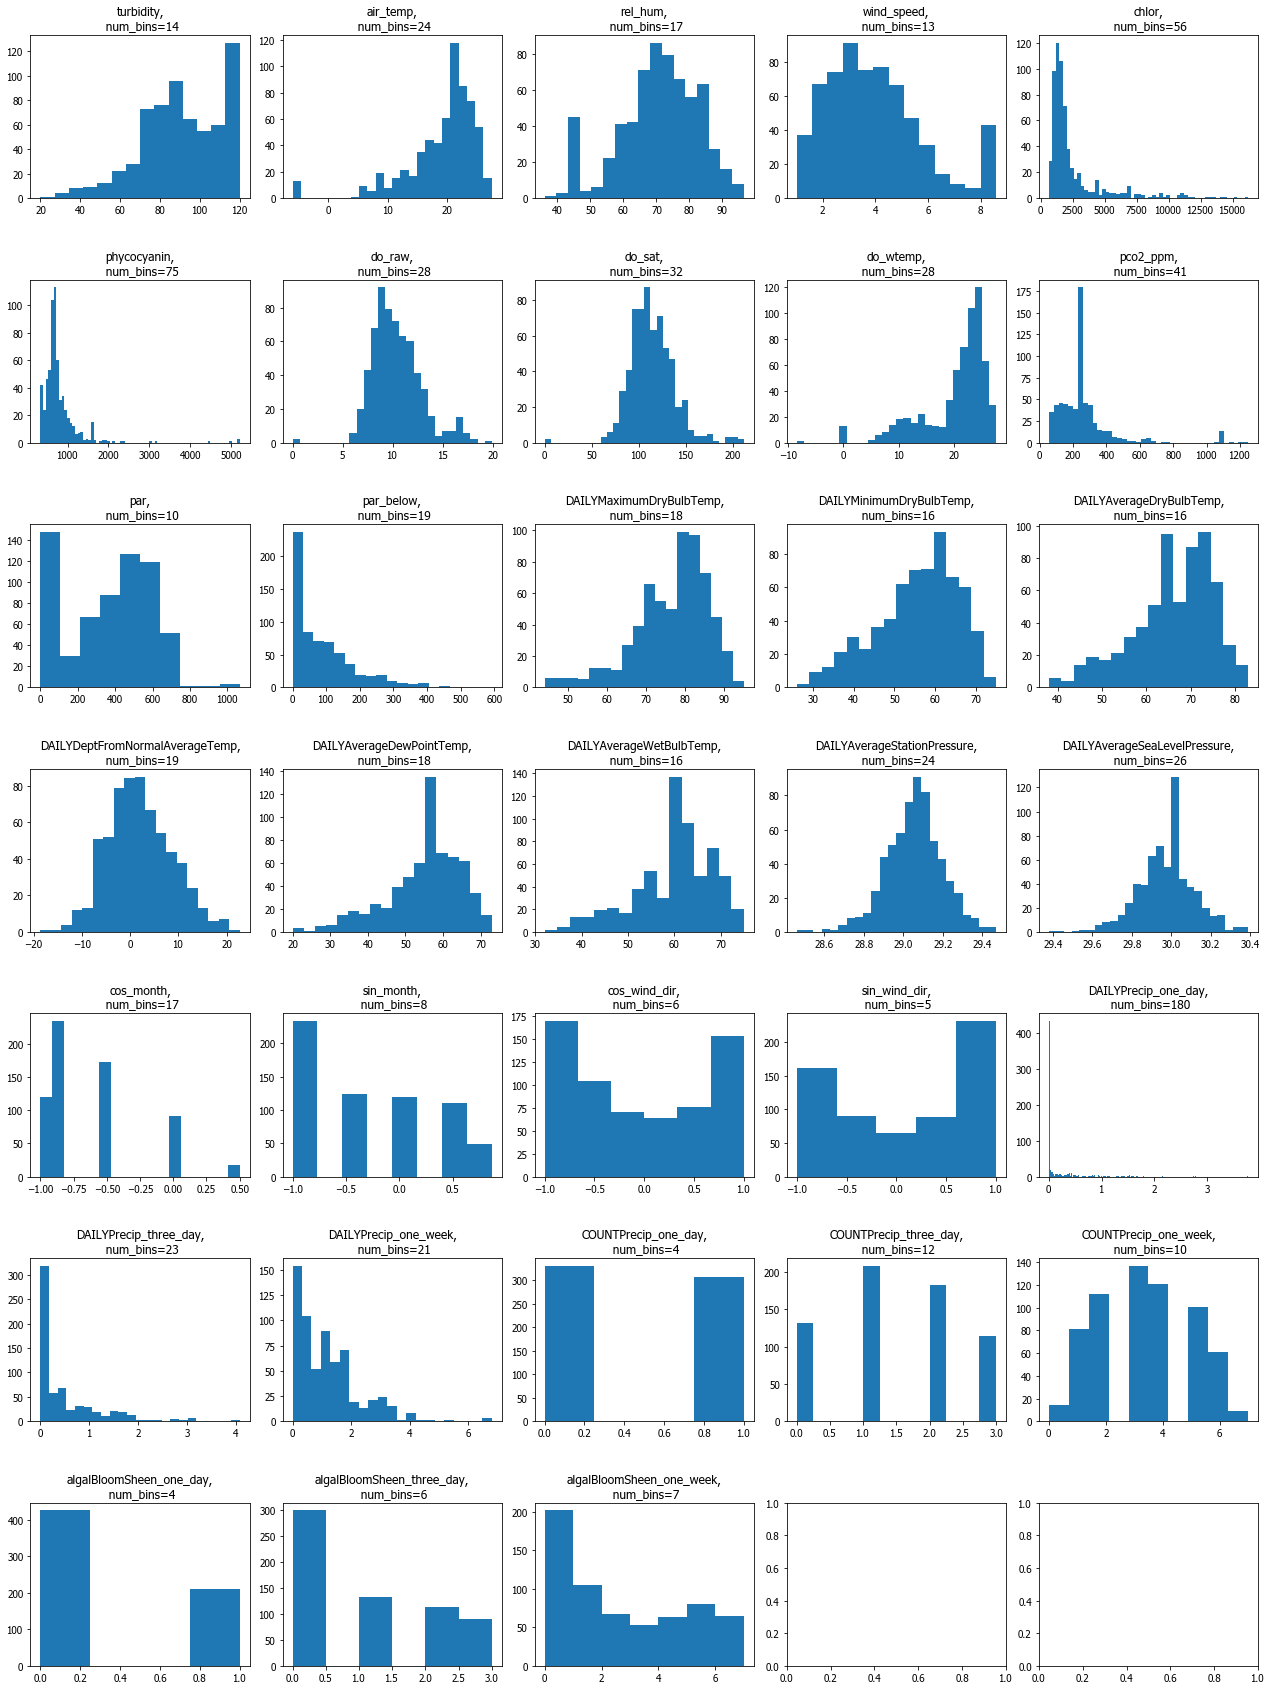

In [19]:
fig, axs = plt.subplots(7, 5, figsize=(22, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.15)

axs = axs.ravel()
n = data.shape[0]

for i in range(data.shape[1]):
    # use Freedman-Diaconis rule to determine number of bins: h=2*IQR*n^(-1/3) ==> # bins = (max-min)/h
    iqr = data.iloc[:, i].quantile(0.75) - data.iloc[:, i].quantile(0.25)
    h = 2*iqr*(n**(-1/3))
    num_bins = int((data.iloc[:, i].max() - data.iloc[:, i].min()) / h)
    
    axs[i].hist(data.iloc[:, i], bins=num_bins)
    axs[i].set_title(data.columns[i] + ',\n num_bins=' + str(num_bins))

## Correlation

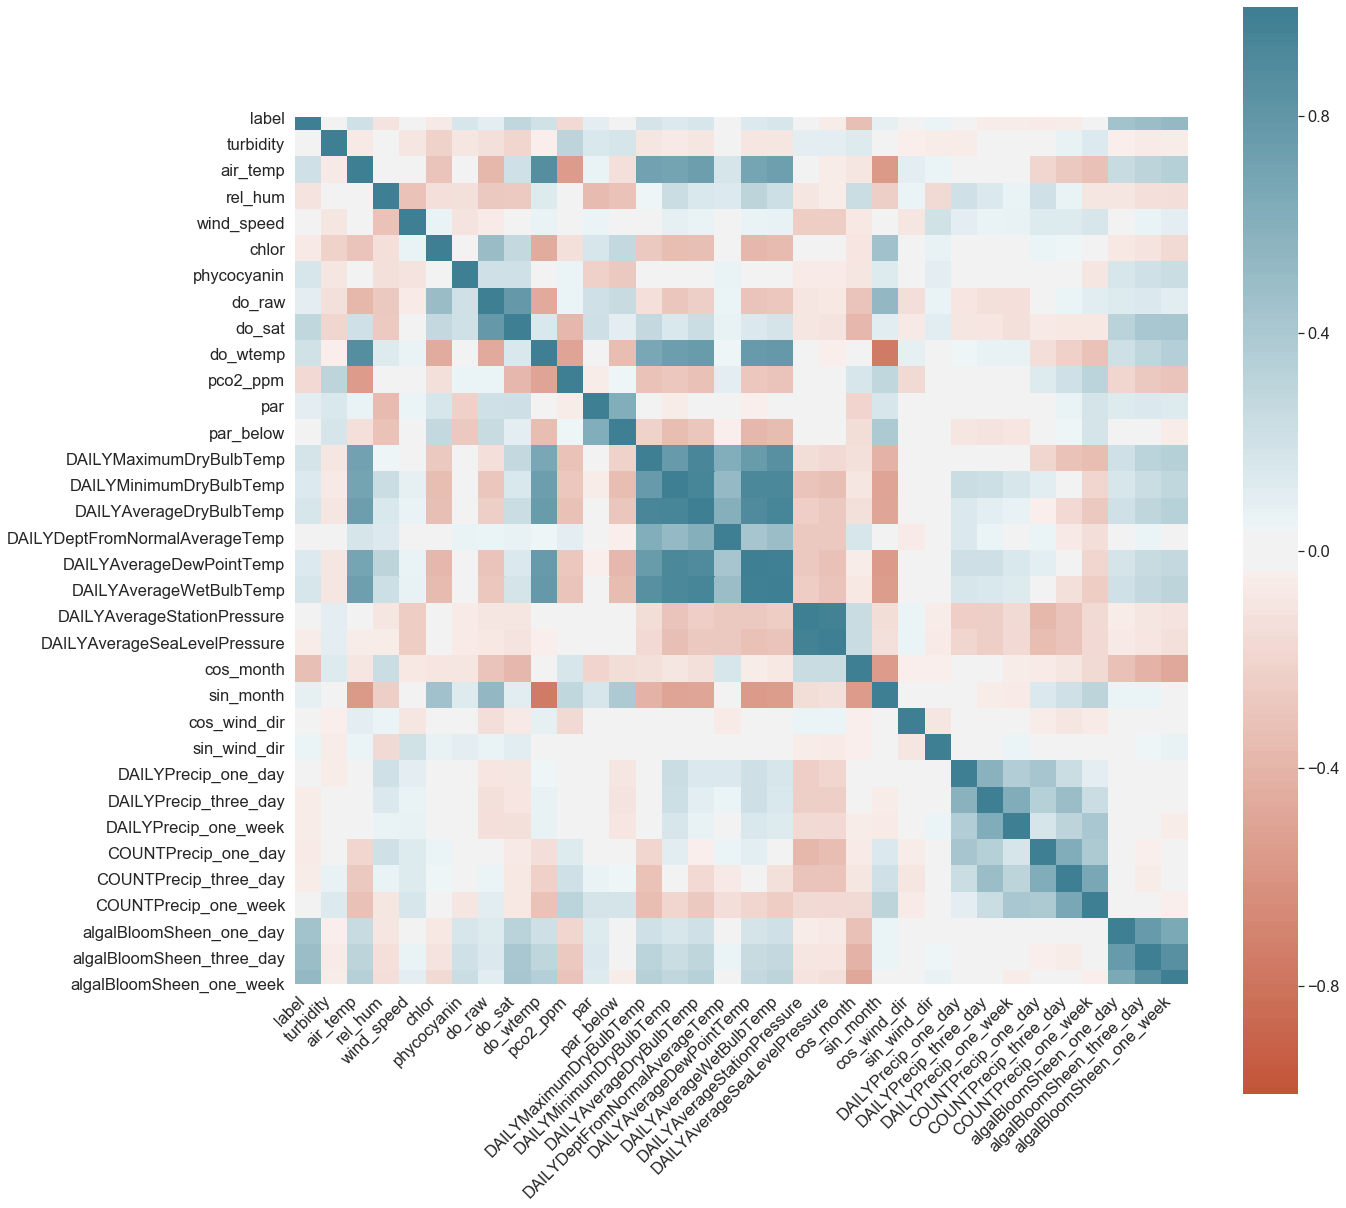

In [60]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);